# Imports

In [21]:
from sklearn.datasets import load_wine
from networkx.drawing.nx_agraph import graphviz_layout
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import networkx as nx
import pandas as pd
import numpy as np
import copy
import uuid

# Code

In [22]:
class Node:
  def __init__(self,
               name: str,
               value : float or int,
               cond_type : int = 0,
               depth : int = 0,
               leaf : bool = False):

    self.name = name
    self.value = value
    self.cond_type = cond_type

    if cond_type == 0: #Categorical
      self.symbol = '<='
    elif cond_type == 1: #Scalar
      self.symbol = '='

    self.depth = depth
    self.leaf = leaf

    self.left = None    #true
    self.right = None   #false

    self.identifier = uuid.uuid4()


  def decision(self,
               x: float or int):

    return x <= self.value if self.cond_type == 0 else  self.value == x


In [23]:
class Tree:

  def __init__(self,
               all_features: np.ndarray,
               targets: np.ndarray,
               max_depth: int = 5):

    self.all_features = all_features
    self.max_depth = max_depth

    self.chosen_features = np.random.choice(self.all_features, max_depth,
                                            replace=True)

    self.features = {feature : self.all_features.index(feature) for feature in self.chosen_features}

    self.targets = targets
    self.root = None
    self.nodes = None

    self.score = 0

  def __deepcopy__(self, obj):
        new = type(self)(copy.deepcopy(self.all_features, obj),
                         copy.deepcopy(self.chosen_features, obj),
                         copy.deepcopy(self.targets, obj),
                         copy.deepcopy(self.max_depth, obj)
                         )
        new.features = copy.deepcopy(self.features, obj)
        new.root = copy.deepcopy(self.root, obj)
        new.nodes = copy.deepcopy(self.nodes, obj)

        return new

  def get_params(self):
    return self.chosen_features, self.max_depth, self.score

  def insert_node(self,
                  node: Node,
                  key_name: str,
                  key_value: float or int = 0,
                  current_depth: int = 0):

    if node is None:
      return Node(key_name, key_value, depth=current_depth, cond_type=0)

    else:
      current_depth += 1
      direction = np.random.rand()
      if direction <= 0.5:
        node.left = self.insert_node(node.left, key_name, key_value, current_depth)
      else:
        node.right = self.insert_node(node.right, key_name, key_value, current_depth)

    return node


  def set_outputs(self,
                  node : Node,
                  outputs_classes: np.ndarray,
                  before_label: str = '',
                  current_depth : int = 0,
                  direction: str = 'right'):

    current_depth += 1

    if node is None:
      label = np.random.choice(outputs_classes)
      value = float(label.split('_')[1])
      return Node(label, int(value), depth=current_depth, leaf=True)

    else:
      if node.right and node.left is None:
        left_output_classes = np.delete(outputs_classes, np.where(outputs_classes == node.right.name))
      else:
        left_output_classes = outputs_classes
      node.left = self.set_outputs(node.left, left_output_classes, node.name, current_depth, direction='left')

      if node.left and node.right is None:
        right_output_classes = np.delete(outputs_classes, np.where(outputs_classes == node.left.name))
      else:
        right_output_classes = outputs_classes
      node.right = self.set_outputs(node.right, right_output_classes, node.name, current_depth)

    return node


  def to_nodes(self,
               node: Node,
               nodes: np.ndarray,):
    if node and not node.leaf:
      nodes.append(node)
      self.to_nodes(node.left, nodes)
      self.to_nodes(node.right, nodes)


  def get_nodes(self):
    nodes = []
    self.to_nodes(self.root, nodes)
    return nodes


  def create(self):
    for feature in self.chosen_features:
      self.root = self.insert_node(self.root, feature, np.random.normal())

    self.root = self.set_outputs(self.root, self.targets)
    self.nodes = self.get_nodes()


  def make_predict(self,
                   cell: np.ndarray):

    node = self.root
    while node:
      if node.leaf:
        return node.value

      elif node.decision(cell[self.features[node.name]]):
        node = node.left

      else:
        node = node.right


  def predict(self,
              data: np.ndarray):
    results = []
    for cell in data:
      results.append(self.make_predict(cell))

    return results


  def to_graph(self,
               graph,
               node: Node):

    if node.left is not None:
        graph.add_edge(node.identifier, node.left.identifier)
        self.to_graph(graph, node.left)

    if node.right is not None:
        graph.add_edge(node.identifier, node.right.identifier)
        self.to_graph(graph, node.right)


  def get_labels(self,
                 node: Node,
                 labels: dict):

    if node:
      labels[node.identifier] = f'{node.name} {node.symbol} {node.value:.4}' if not node.leaf else f'{node.name}'
      self.get_labels(node.left, labels)
      self.get_labels(node.right, labels)


  def show(self):
    graph = nx.Graph()
    self.to_graph(graph, self.root)

    labels = {}
    self.get_labels(self.root, labels)
    pos = graphviz_layout(graph, prog="dot")

    plt.figure(figsize=(13, 5))
    nx.draw(graph, pos,
            labels=labels,
            with_labels=True,
            node_size=500,
            font_size=10,
            font_color="white",
            font_weight="bold",
            linewidths=0.5,
            edge_color="gray",
            style="dashed",
            bbox=dict(facecolor="black", edgecolor='black', boxstyle='round, pad=1.0'))

    plt.show()

- Grupo de elite, resta em 25 epoca, tem taxa de mutação grandano na diagonal principal (em dos nos nos 5*) e na outra a taxa pequena
- Esquema de roleta para ver o numero de cromossomos a serem mutados, da pra fazer uma ppf
- 80 torneio, 20 melhor de todos
-  predação randomica, m piores

In [24]:
class Genetic:

  def __init__(self,
               pop_size: int,
               epochs: int,
               model: Tree,
               x_data,
               y_data,
               mutation_rate: float = 4e-2,
               documentation = False):

    # Parameters AG
    self.epochs = epochs
    self.pop_size = pop_size
    self.model = model
    self.mutation_rate = mutation_rate
    self.save_rate = mutation_rate
    
    # Properties AG
    self.n_nodes = len(model.nodes)
    self.population = []
    self.scores = []
    self.no_improvement = 0
    self.patience_genocide = 0
    self.x = x_data
    self.y = y_data
    
    
    self.elite_pop = []
    self.elite_mutation = .05
    
    # Best individual
    self.best = None
    self.best_score = None
    self.elite_is_best = []
    self.population_is_best = []
    
    # Worst individual
    self.worst = None
    self.worst_score = None
    self.worst_idx = 0
        
    # Save data
    self.documentation = documentation

    self.tournam_history = []
    self.population_history = []
    self.best_history = []
    self.results = pd.DataFrame(columns = ['epoch', 'agent', 'mutation', 'best_score', 'score'])
    self.results_elite = pd.DataFrame(columns = ['epoch', 'agent', 'best_score', 'score', 'individuo'])
    # self.results_train = pd.DataFrame(columns = ['epoch', 'best_score', 'mutation_rate'])
    self.control_cross = []
      
  def start_pop(self):
    self.population = np.random.normal(size=(self.pop_size, self.n_nodes))
    self.elite_pop = np.random.normal(size=(self.n_nodes, self.n_nodes))
    
    self.best = self.population[0]
    self.best_score = 0
  
    self.worst = self.population[0]
    self.worst_score = 1
    self.worst_idx = 0
  
  def set_elite(self):
    for i in range(self.n_nodes):
      cross_best = self.best
      cross_best[i] *= (1 + 5*self.elite_mutation) if np.random.rand() < 0.50 else (1 - 5*self.elite_mutation)
      self.elite_pop[i] = cross_best.copy()
  
  
  def set_best(self, agent, score, idx):
    self.best = agent.copy() # salva o melhor para cross over
    self.best_score = score
    self.mutation_rate = self.save_rate
    self.no_improvement = 0
  
  def set_worst(self, agent, score, idx):
    self.worst = agent
    self.worst_score = score
    self.worst_idx = idx
      
      
      
  def evaluation_function(self,
                          data: np.ndarray,
                          target: np.ndarray,
                          sample_size: int):

    return sum(self.model.predict(data) == target) / sample_size
 
  def evaluation(self,
                 data: np.ndarray,
                 target: np.ndarray,
                 epoch: int):

    sample_size = len(target)
    self.scores = []
    
    # Avaliacao elite
    for i, agent in enumerate(self.elite_pop):
      for node, value in zip(self.model.nodes, agent):
        node.value = value
      score = self.evaluation_function(data, target, sample_size)
      self.results_elite.loc[len(self.results_elite)] = [epoch, i ,self.best_score, score, agent.copy()]
      if (score > self.best_score):
        self.set_best(agent, score, i)
        self.elite_is_best.append(epoch)
    
    # Avaliacao populacao geral
    for i, agent in enumerate(self.population):
      for node, value in zip(self.model.nodes, agent):
        node.value = value
      score = self.evaluation_function(data, target, sample_size)
      self.results.loc[len(self.results)] = [epoch, i, self.mutation_rate ,self.best_score, score] 
      self.scores.append(score)
      if (score > self.best_score):
        self.set_best(agent, score, i)
        self.population_is_best.append(epoch)
      if (score < self.worst_score): self.set_worst(agent, score, i)
        
  
  def tournament(self, general = True):
    idx_father = np.random.randint(0,self.pop_size)
    if general:
      idx_mother = np.random.randint(0,self.pop_size)
      if idx_father == idx_mother: idx_father = np.random.randint(0,self.pop_size)
    else:
      batch_best_size = int(self.pop_size / 7) # 14% da populacao
      batch_indexes = np.argsort(self.scores)[::-1]
      batch_best = batch_indexes[:batch_best_size]
      idx_mother = batch_best[np.random.randint(0,batch_best_size)]
      if idx_father == idx_mother: idx_father = np.random.randint(0,self.pop_size)

    son = (self.population[idx_father] + self.population[idx_mother]) / 2
    return son  
          
  def cross_and_mutation(self, general_pop = True):
    population = self.population if general_pop else self.elite_pop
    
    # elitismo para população geral -> repordução sexuada
    if general_pop:
      new_pop = []
      for i in range(self.pop_size):
        if np.random.rand() < 0.30: # elitismo -> melhor de todos
          cross_best = (population[i] + self.best) / 2
          self.control_cross.append('best')
        else:
          cross_best = self.tournament(general = True)
          self.control_cross.append('tourn')
        idx = np.random.randint(0, self.n_nodes)
        mutation = np.random.normal() * self.mutation_rate
        cross_best[idx] += 2*mutation if np.random.rand() < 0.50 else -2*mutation # espaço de busca = 2 (+- valor eixo)
        new_pop.append(cross_best.copy())
      new_pop = np.vstack(new_pop)
      
      for i in range(self.pop_size):
        population[i] = new_pop[i]
      
    # reprodução assexuada para grupo elite 
    else:
      for i, agent in enumerate(population):
        for _ in range(3): # colocar proporcional ao tamanho do cromossomo?
          idx = np.random.randint(0, self.n_nodes)
          agent[idx] *= (1 + self.elite_mutation) if np.random.rand() < 0.50 else (1 - self.elite_mutation) # ajuste fino -> % no valor e não no espaço de busca
        population[i] = agent.copy()
      
  def predation_rand(self, index = None):
    if index == None: # so mata o pior
      self.population[self.worst_idx] = np.random.normal(size=(1, self.n_nodes))
    else: # mata um batch de ruins
      self.population[index] = np.random.normal(size=(1, self.n_nodes))
  
  def train(self):

    self.start_pop()
    if self.documentation: self.population_history = [self.population.copy()]
    
    flag_pred = 0
    for i in range(self.epochs):
      x_sample, y_sample = resample(self.x, self.y, stratify = self.y)  
      
      # se a media do desvio padrao de todos os genes da população menor que 0.05 -> baixa diversidade
      low_diversity = (np.mean(self.calculate_diversity(self.population)) < 0.05)
      flag_pred += 1 if low_diversity else 0
      
      # Criterio de aumento da mutacao caso fit esteja estagnado
      self.no_improvement += 1
      self.patience_genocide += 1
      
      # A cada 20 epoch faz grupo "elite" -> buscar ajuste fino
      if ((i % 20 == 0) or (i == 10)):
        self.set_elite()
      
      self.evaluation(x_sample, y_sample, i) # Avalia os indivíduos
      
      if self.no_improvement == 7:
        self.mutation_rate *= 1.15
        self.no_improvement = 0


      if self.patience_genocide == 40:
        self.population = np.random.normal(size=(self.pop_size, self.n_nodes))
        self.mutation_rate = self.save_rate
        self.patience_genocide = 0
        self.no_improvement = 0
        flag_pred = 0
      
      
      if flag_pred == 10:
        # substituindo um batch de ruins
        batch_worst_size = int(self.pop_size / 7) # 14% da populacao
        batch_worst = sorted(range(len(self.scores)), key=lambda x: self.scores[x])[:batch_worst_size]
        for bad_indiv in batch_worst:
          self.predation_rand(bad_indiv)
        flag_pred = 0
        # # Substituindo o pior de todos
        # self.worst_idx = self.scores.index(min(self.scores))
        # self.predation_rand()
  
      self.cross_and_mutation(general_pop = True)
      self.cross_and_mutation(general_pop = False)
      # self.results_train.loc[len(self.results)] = [i, self.best_score, self.mutation_rate]
      
      if self.documentation:
        self.population_history.append(self.population.copy())
        self.best_history.append(self.best_score.copy())
      

  def calculate_diversity(self, population):
      return np.std(population, axis=0).mean()
  
  def track_diversity(self):
      diversities = [self.calculate_diversity(pop) for pop in self.population_history]
      return diversities
  
  def plot_diversity(self):
    fig, ax = plt.subplots(1, 1, figsize = (10,6))
    diversities = self.track_diversity()
    ax.hlines(y = 0.1, xmin = 0, xmax = self.epochs)
    ax.plot(range(len(diversities)), diversities, marker='o', linestyle='-')
    ax.set_title('Diversity Over Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Diversity')
    ax.grid(True)
    return fig, ax
      
  def track_convergence_speed(self):
    convergence_speed = [self.best_history[i + 1] - self.best_history[i] for i in range(len(self.best_history) - 1)]
    return convergence_speed
  
  def plot_convergence_speed(self):
    fig, ax = plt.subplots(1, 1, figsize = (10,6))
    convergence_speed = self.track_convergence_speed()
    ax.plot(range(len(convergence_speed)), convergence_speed, marker='o', linestyle='-')
    ax.set_title('Convergence Speed')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Improvement in Best Score')
    return fig, ax
  
  def plot_diagnosis(self, gen_pop = False):
    fig, axs = plt.subplots(1, 2, figsize = (20,6))
    ax = axs[0]
    diversities = self.track_diversity()
    ax.hlines(y = 0.1, xmin = 0, xmax = self.epochs)
    ax.plot(range(len(diversities)), diversities, marker='o', linestyle='-')
    ax.set_title('Diversity Over Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Diversity')
    ax.grid(True)

    ax = axs[1]
    convergence_speed = self.track_convergence_speed()
    ax.plot(range(len(convergence_speed)), convergence_speed, marker='o', linestyle='-')
    ax.set_title('Convergence Speed')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Improvement in Best Score')
      
  
  def plot_pop(self):
    populations = {"General population" : self.results,
                   "Elite population" : self.results_elite}
    
    fig, axs = plt.subplots(1, 2, figsize = (20,8))
    
    for i, (title, population) in enumerate(populations.items()):
      ax = axs[i]
      
      for agent in population['agent'].unique():
        data = population.loc[population['agent'] == agent]
        ax.plot(data['epoch'], data['score'], alpha = 0.33)
            
      mean_scores = population.groupby('epoch')['score'].mean().reset_index()
      max_scores = population.groupby('epoch')['score'].max().reset_index()
      
      ax.plot(mean_scores['epoch'], mean_scores['score'], color = 'black', lw = 4, label='Mean Score')
      ax.plot(max_scores['epoch'], max_scores['score'], color = 'red', lw = 3, ls = 'dashed', label='Mean Score')
      ax.plot(max_scores['epoch'], self.best_history, color = 'blue', lw = 4, ls = ':', label='Best Score')
      ax.set_title(title)
      ax.set_xlabel('Epochs')
      ax.set_ylabel('Score')
      ax.set_ylim(0, 1)


In [25]:
def model_pred(n_class: int,
               agents: list,
               data: np.ndarray):

  pred = []
  probs = []
  for x in data:
    prob = np.zeros(n_class)

    for tree in agents:
      result = tree.make_predict(x)
      prob[result] += 1

    pred.append(np.argmax(prob))
    probs.append(prob)
      
  return pred, probs

def model_prob(n_class: int,
               agents: list,
               data: np.ndarray,
               agent_weight: np.ndarray):
  predictions = []
  probability = []
  for x in data:
    prob = np.zeros(n_class)
  
    for tree, weight in zip(agents, agent_weight):
      result = tree.make_predict(x)
      prob[result] += weight
  
    predictions.append(np.argmax(prob))
    probability.append(prob)
  return predictions, probability


def score(y_pred, y):
  s = sum(y_pred == y) / len(y)

  print(f'Score :: {s}')
  

# Wine

seed = 12
np.random.seed(seed)

data = load_wine()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
features = data['feature_names']
targets = data['target_names']

Y = data['target']
X = df.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify = Y)

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed, stratify = y_train)

In [26]:
n_models = 30
n_epochs = 250
n_population = 100
tree_depth = 16

results = pd.DataFrame(columns = ['chosen_features', 'max_depth', 'score'])
results_AG = pd.DataFrame(columns = ['modelo', 'epoch', 'best_score', 'mutation_rate'])

np.random.seed(seed)
models = []

for _ in range(n_models):
  model = Tree(features, targets, max_depth=tree_depth)
  model.create()
  models.append(model)
  results.loc[len(results)] = model.get_params()

print('Random Models Score')
y_pred_pre, y_probs_pre = model_pred(len(targets), models, x_test)
score(y_pred_pre, y_test)
print()


agents = []
i = 0
for model in tqdm(models, desc='Traning Models :: ', total=n_models):

  genetic = Genetic(n_population, n_epochs, model, x_tr, y_tr , documentation = True)
  genetic.train()
  agents.append( genetic.model )
  results = genetic.results.copy()
  results.insert(0, 'modelo', [i]*len(results))

  results_AG = pd.concat([results_AG, results], ignore_index = True)
  i += 1
  
y_pred, y_probs = model_pred(len(targets), agents, x_test)

score(y_pred, y_test)

Random Models Score
Score :: 0.4722222222222222


Traning Models ::   0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\arthu\AppData\Local\Temp\ipykernel_11988\993716067.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_AG = pd.concat([results_AG, results], ignore_index = True)


Score :: 0.8888888888888888


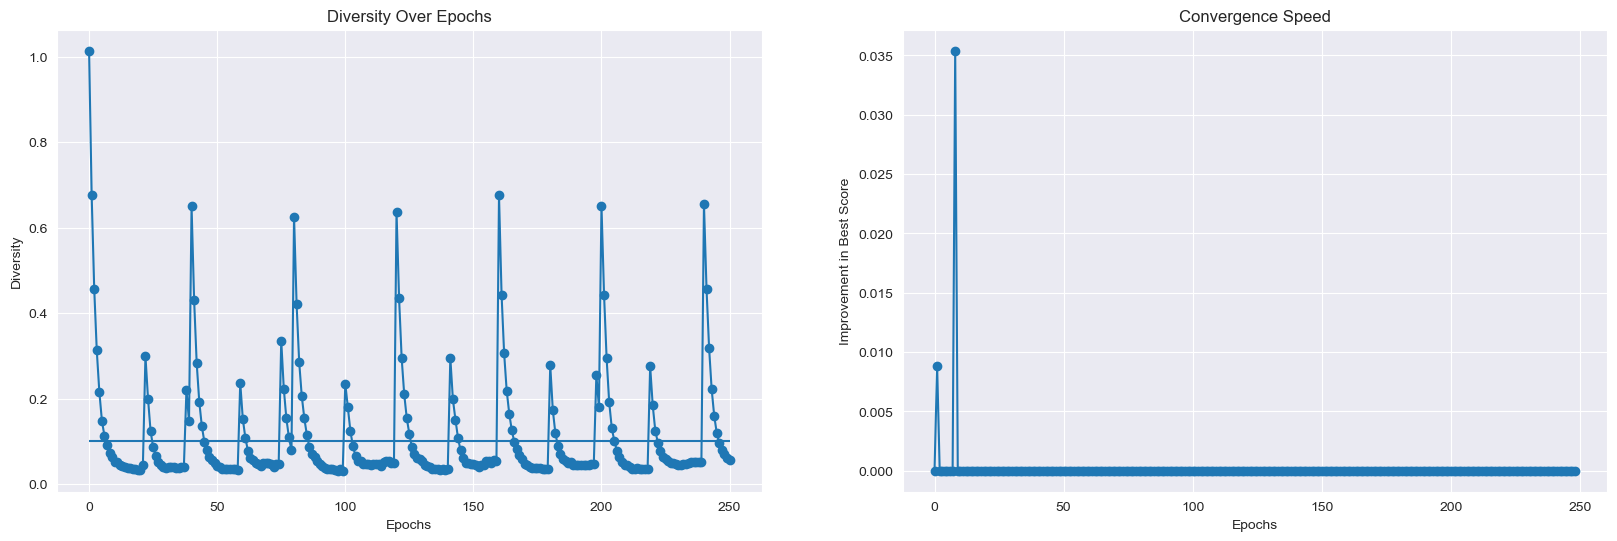

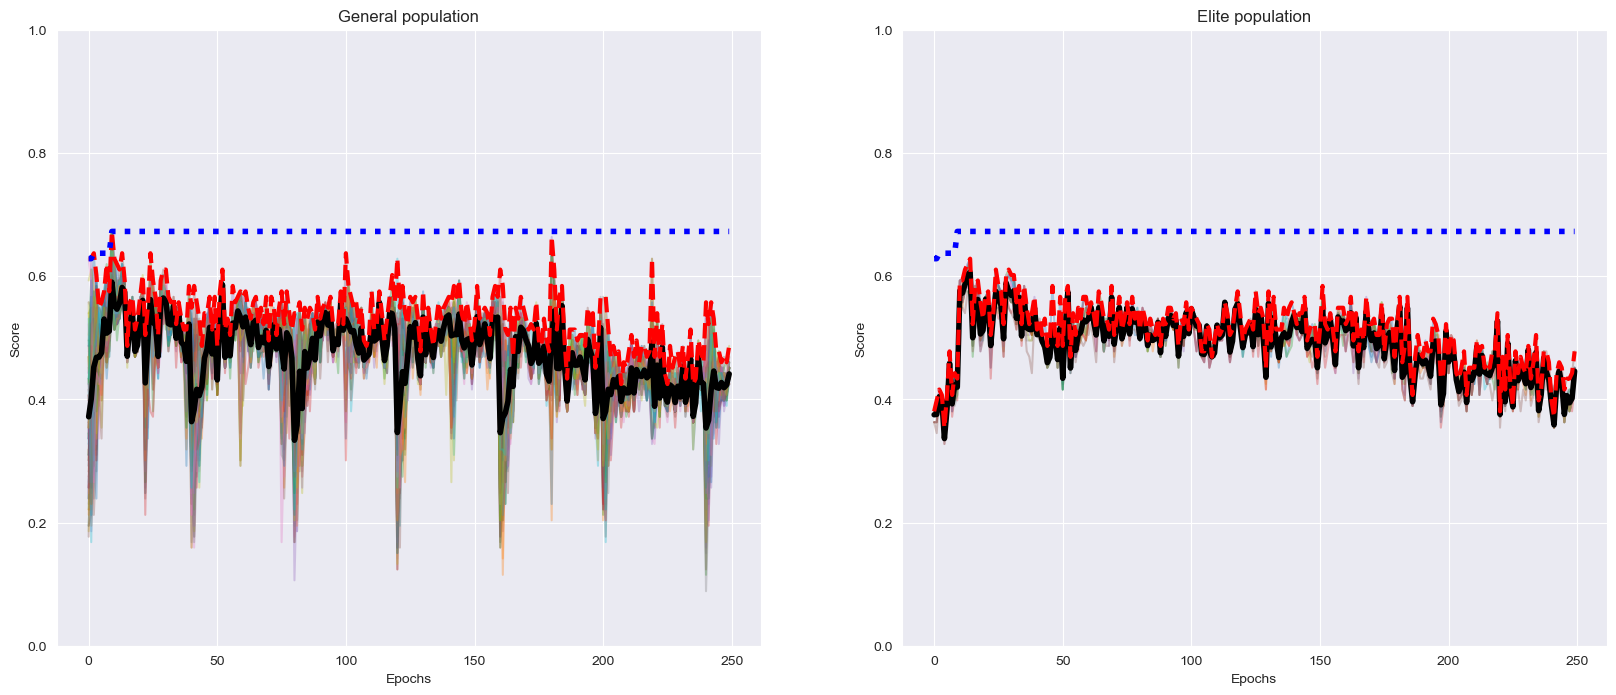

In [27]:
genetic.population_is_best, genetic.elite_is_best
genetic.plot_diagnosis()
genetic.plot_pop()

In [28]:
# Get unique values and their counts
unique_values, counts = np.unique(genetic.control_cross, return_counts=True)

# Combine unique values and counts
value_counts = dict(zip(unique_values, counts))

# Print the counts of unique values
print(value_counts)

{'best': 7510, 'tourn': 17490}


# EM ANDAMENTO

In [98]:
class Genetic_Ensemble:

  def __init__(self,
               agents : ['tree'],
               epochs: int,
               pop_size,
               x_data,
               y_data,
               mutation_rate: float = 4e-2):

    # Parameters AG
    self.epochs = epochs
    self.mutation_rate = mutation_rate
    self.save_rate = mutation_rate
    self.agents = agents
    self.n_agents = len(self.agents)
    
    self.x = x_data
    self.y = y_data
    
    # Properties AG
    self.population_size = pop_size
    self.population = self.start_pop()
    self.pop_init = self.population.copy()
    self.scores = []
    self.no_improvement = 0
    self.patience_genocide = 0
    
    # Best individual
    self.best = self.population[0]
    self.best_score = 0
    self.best_dict = {}
   
    self.results = pd.DataFrame(columns = ['epoch', 'agent', 'mutation', 'best_score', 'score'])

    self.pred = {}
    self.prob = {}
      
    self.population_history = []
    self.best_history = []
      
  def start_pop(self):
    random_matrix = np.random.randn(self.population_size, self.n_agents)
    for row in random_matrix:
      while np.random.rand() < 0.40:
        idx = np.random.randint(0, self.n_agents)
        row[idx] = 0
          
    normalized_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)
    
    return normalized_matrix
  
  def pred_prob(self,
                data,
                n_class: int):
    predictions = {}
    probability = {}
    
    
    for i, individual in enumerate(self.population):
      predictions[i] = []
      probability[i] = []
      for x in data:
        prob = np.zeros(n_class)
        for tree, weight in zip(self.agents, individual):
          result = tree.make_predict(x)
          prob[result] += weight
      
        predictions[i].append(np.argmax(prob))
        probability[i].append(prob)
    
    self.pred = predictions
    self.prob = probability
    return predictions, probability
    

  def set_best(self, agent, score, idx):
    self.best = agent.copy() # salva o melhor para cross over
    if(self.best_score == score):
      self.best_dict[score] = agent.copy()
    self.best_score = score
    self.mutation_rate = self.save_rate
    self.no_improvement = 0
      
      
  def evaluation_function(self, y_pred, y):
    return sum(y_pred == y) / len(y)


  def evaluation(self,
                 epoch: int):

    x_ts_prob, y_ts_prob = resample(self.x, self.y, stratify = self.y)
    
    y_pred_prob, _ = self.pred_prob(data = x_ts_prob, n_class = len(np.unique(y_ts_prob)))
    self.scores = []
    for i, individual in enumerate(self.population):
      
      score = self.evaluation_function(y_pred_prob[i], y_ts_prob)
      self.results.loc[len(self.results)] = [epoch, i, self.mutation_rate ,self.best_score, score] 
      self.scores.append(score)
      if (score > self.best_score):
        self.set_best(individual, score, i)
      # if (score < self.worst_score): self.set_worst(agent, score, i)
  
  def predation_rand(self, index = None):
    if index == None: # so mata o pior
      self.population[self.worst_idx] = np.random.normal(size=(1, self.n_nodes))
    else: # mata um batch de ruins
      new = np.random.randn(1, self.n_agents)
      self.population[index] = new / np.sum(new)
  
  def cross_and_mutation(self):
    for i, agent in enumerate(self.population):
      # if general_pop:

      # elitismo para população geral -> repordução sexuada
      cross_best = (agent + self.best) / 2
      idx = np.random.randint(0, self.n_agents)
      mutation = np.random.normal() * self.mutation_rate
      cross_best[idx] += 2*mutation if np.random.rand() < 0.50 else -2*mutation # espaço de busca = 2 (+- valor eixo)
      self.population[i] = (cross_best / np.sum(cross_best)).copy()
        
  
  def train(self):
    

    flag_pred = 0
    for i in range(self.epochs):
      
      # se a media do desvio padrao de todos os genes da população menor que 0.05 -> baixa diversidade
      low_diversity = (np.mean(self.calculate_diversity(self.population)) < 0.05)
      flag_pred += 1 if low_diversity else 0
      
      # Criterio de aumento da mutacao caso fit esteja estagnado
      self.no_improvement += 1
      self.patience_genocide += 1
      
      # A cada 20 epoch faz grupo "elite" -> buscar ajuste fino
      # if ((i % 30 == 0) or (i == 10)):
      #   self.set_elite()
      # 
      self.evaluation(epoch =  i) # Avalia os indivíduos
      
      if self.no_improvement == 7:
        self.mutation_rate *= 1.15
        self.no_improvement = 0


      if self.patience_genocide == 40:
        self.population = self.start_pop()
        self.mutation_rate = self.save_rate
        self.patience_genocide = 0
        self.no_improvement = 0
        flag_pred = 0
      
      
      if flag_pred == 10:
        # substituindo um batch de ruins
        batch_worst_size = int(self.population_size / 7) # 14% da populacao
        batch_worst = sorted(range(len(self.scores)), key=lambda x: self.scores[x])[:batch_worst_size]
        for bad_indiv in batch_worst:
          self.predation_rand(bad_indiv)
        flag_pred = 0

  
      self.cross_and_mutation()
      # self.results_train.loc[len(self.results)] = [i, self.best_score, self.mutation_rate]

      self.population_history.append(self.population.copy())
      self.best_history.append(self.best_score.copy())
          
          
  def calculate_diversity(self, population):
    return np.std(population, axis=0).mean()
  
  def track_diversity(self):
      diversities = [self.calculate_diversity(pop) for pop in self.population_history]
      return diversities
  
  def plot_diversity(self):
    fig, ax = plt.subplots(1, 1, figsize = (10,6))
    diversities = self.track_diversity()
    ax.hlines(y = 0.1, xmin = 0, xmax = self.epochs)
    ax.plot(range(len(diversities)), diversities, marker='o', linestyle='-')
    ax.set_title('Diversity Over Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Diversity')
    ax.grid(True)
    return fig, ax
      
  def track_convergence_speed(self):
    convergence_speed = [self.best_history[i + 1] - self.best_history[i] for i in range(len(self.best_history) - 1)]
    return convergence_speed
  
  def plot_convergence_speed(self):
    fig, ax = plt.subplots(1, 1, figsize = (10,6))
    convergence_speed = self.track_convergence_speed()
    ax.plot(range(len(convergence_speed)), convergence_speed, marker='o', linestyle='-')
    ax.set_title('Convergence Speed')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Improvement in Best Score')
    return fig, ax
  
  def plot_diagnosis(self, gen_pop = False):
    fig, axs = plt.subplots(1, 2, figsize = (20,6))
    ax = axs[0]
    diversities = self.track_diversity()
    ax.hlines(y = 0.1, xmin = 0, xmax = self.epochs)
    ax.plot(range(len(diversities)), diversities, marker='o', linestyle='-')
    ax.set_title('Diversity Over Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Diversity')
    ax.grid(True)

    ax = axs[1]
    convergence_speed = self.track_convergence_speed()
    ax.plot(range(len(convergence_speed)), convergence_speed, marker='o', linestyle='-')
    ax.set_title('Convergence Speed')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Improvement in Best Score')
      
  
  def plot_pop(self):
    population = self.results
    
    fig, ax = plt.subplots(1, 1, figsize = (20,8))

    for agent in population['agent'].unique():
      data = population.loc[population['agent'] == agent]
      ax.plot(data['epoch'], data['score'], alpha = 0.33)
          
    mean_scores = population.groupby('epoch')['score'].mean().reset_index()
    max_scores = population.groupby('epoch')['score'].max().reset_index()
    
    ax.plot(mean_scores['epoch'], mean_scores['score'], color = 'black', lw = 4, label='Mean Score')
    ax.plot(max_scores['epoch'], max_scores['score'], color = 'red', lw = 3, ls = 'dashed', label='Mean Score')
    ax.plot(max_scores['epoch'], self.best_history, color = 'blue', lw = 4, ls = ':', label='Best Score')
    ax.set_title("General population")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)

In [99]:
noise = np.random.normal(0, 0.1, x_tr.shape)
tr_noisy = x_tr + noise

x_noisy = np.vstack([tr_noisy, x_val])
y_train_ensemb= np.concatenate([y_tr, y_val])

Score :: 0.9166666666666666
Score :: 0.9722222222222222


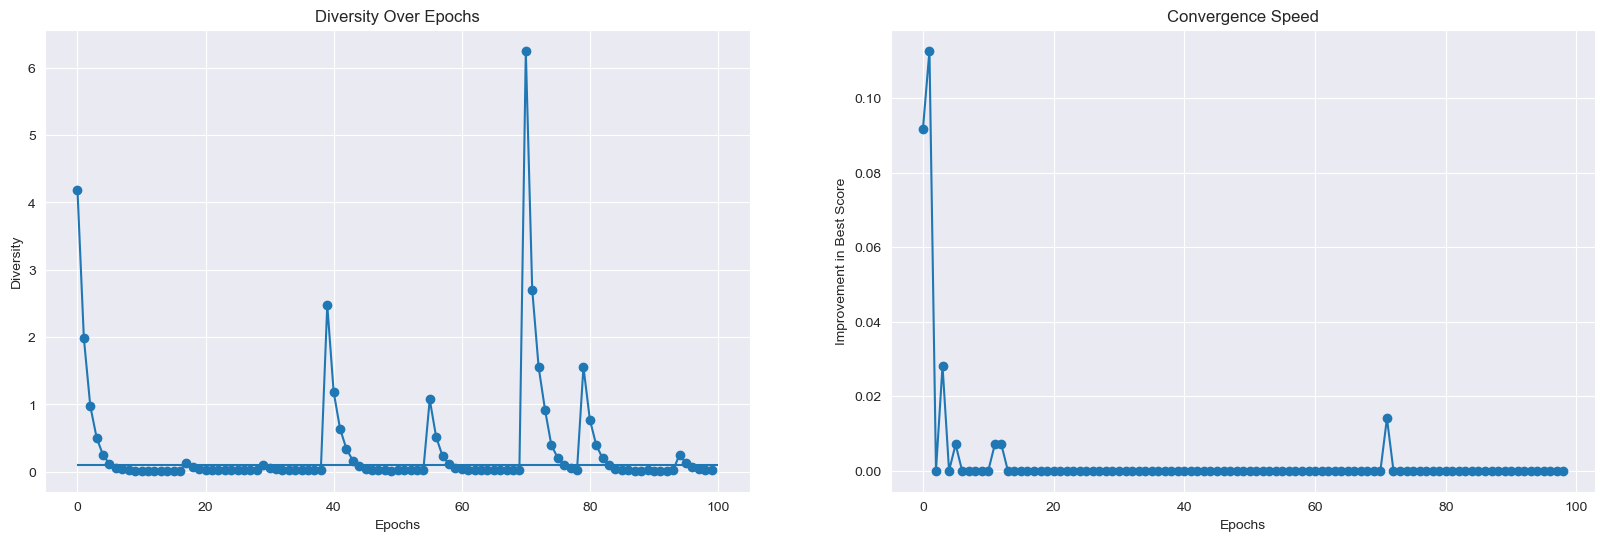

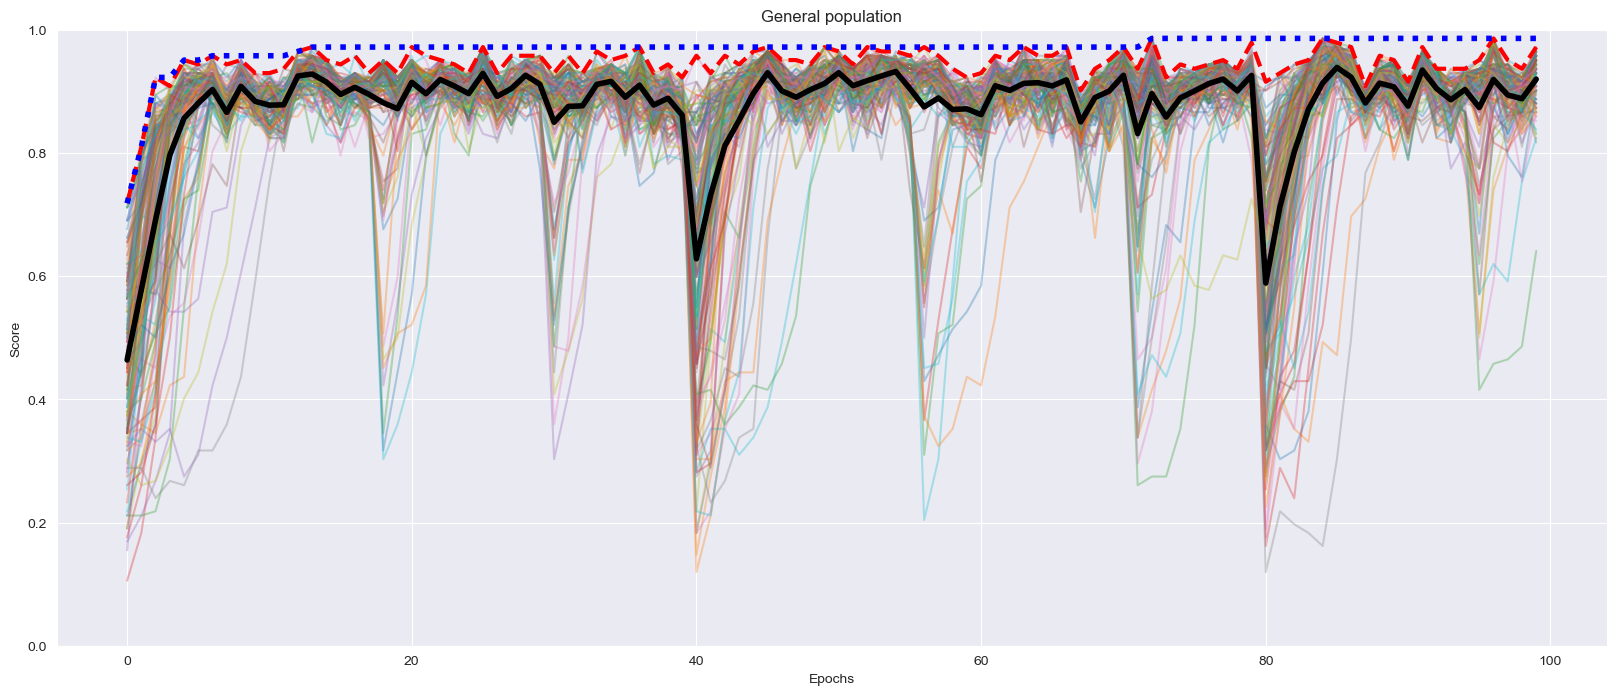

In [100]:
ensemble_test = Genetic_Ensemble(agents, 100, 150, x_noisy, y_train_ensemb)
ensemble_test.train()
ensemble_test.plot_diagnosis()
ensemble_test.plot_pop()
y_pred_prob, weighted_probs = model_prob(data = x_test, n_class = len(targets),
                                         agents = agents, agent_weight = ensemble_test.best)

s_prob = score(y_pred_prob, y_test)
score(y_pred, y_test)

In [101]:
ensemble_test.best_dict

{}

In [31]:
df_file = pd.read_csv('resultados_AG.csv')
df_file.loc[df_file['score_pos'] == df_file['score_pos'].max()]

,n_models,n_epochs,n_population,score_pre,score_pos,time
3,20.0,75.0,150.0,0.629630,0.981481,140.050545
27,30.0,100.0,125.0,0.444444,0.981481,273.879413
31,30.0,125.0,100.0,0.444444,0.981481,237.955362
52,35.0,125.0,125.0,0.314815,0.981481,361.879672
56,35.0,150.0,100.0,0.314815,0.981481,347.313499
65,40.0,100.0,75.0,0.370370,0.981481,196.178422
102,70.0,75.0,125.0,0.351852,0.981481,551.001703


In [32]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100,
                             random_state=seed,
                             max_depth=8,
                             bootstrap=True)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

score(y_pred, y_test)

Score :: 0.9722222222222222


In [33]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

score(y_pred, y_test)

Score :: 0.9722222222222222
